In [43]:
import pickle
import pandas as pd
import numpy as np
from fastai.text import *

# Get all the data

In [44]:
with open('gdr_assignment_pros_cons.pkl', 'rb') as f:
    data1 = pickle.load(f)
data1 = pd.concat([data1.pros, data1.cons], ignore_index=True)
print(data1.shape)
data1.head()

(10000,)


0                       Company and culture are great!
1    Company culture, autonomy, global strategy, te...
2    Not micromanaged.  Co workers were good.  Pay ...
3    Great work environment, fast paced, hard worki...
4    I love working with dogs and people. I enjoy i...
dtype: object

In [45]:
with open('gdr_assignment_labelled.pkl', 'rb') as f:
    data2 = pickle.load(f)
print(data2.shape)
data2.head()

(8000, 2)


,label,pp_sent
16,[Job Security/Advancement],developing your skills
149,"[Job Security/Advancement, business_vision_com...",rapidly growing
220,[Job Security/Advancement],easy to get your foot in the door
233,[Job Security/Advancement],opportunity for advancement
396,[Job Security/Advancement],career growth options


# Fine Tune Language model using all text available 

In [53]:
train = pd.concat([data2['pp_sent'], data1], ignore_index=True)
train = train.rename('pp_sent').to_frame()

# Remove punctuation or symbol from the text data
train['pp_sent'] = train['pp_sent'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’-])', '')
train['pp_sent'] = train['pp_sent'].str.replace('\r\n', '')


# Create databunch
data = (TextList.from_df(train, cols='pp_sent')
                .split_by_rand_pct(0.25)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,knowledge xxbos personal development xxbos i have learnt a lot xxbos opportunity for advancement if you are willing to work your butt off xxbos good career progression without having to give up too much of what you enjoy if you like the hands on work rather than management xxbos lots of excitement around the company 's growth potential xxbos looks good on a resume xxbos fast learning experience xxbos fast
1,business model is brilliant xxbos eventbrite is a forward thinking company xxbos most people work like xxunk chickens since their is serious lack of direction in management xxbos forward thinking xxbos for the business model xxbos solving the challenges of a rapidly growing company is what gives meaning to the work xxbos culture is really hit or miss some groups are a great close knit group xxbos there have been
2,co workers are all extremely talented xxbos mostly relaxed atmosphere xxbos great team spirit xxbos little micro management if you are a senior level guy xxbos ebay hires solid people at the individual contributor level xxbos all my co workers are hard working xxbos better internal communication xxbos healthy competition xxbos helpful culture from top to bottom xxbos too see customers dogs come in excited as can be while in
3,from specific managers who have trouble xxunk frustration in a mature xxbos definitely the old boys network rules here xxbos not very woman or minority friendly xxbos a place for white males xxbos favoritism is rampant when junior associates get bumped up promoted ahead of senior associates due to who they know xxbos as well as it being a boys club xxbos still the german white male at the top
4,xxbos senior management team xxbos they truly care about your pets xxbos workday has brought in several new senior leaders in the past xxunk months xxbos an accessible upper management xxbos the ceo is a very charismatic leader xxbos or they ' ve been treated badly before xxbos senior management is working to make this a company for the long term xxbos everything is based on leadership principles xxbos most


In [56]:
# Fit the deep learning model with domain specific data
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)


In [57]:
# select the appropriate learning rate
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


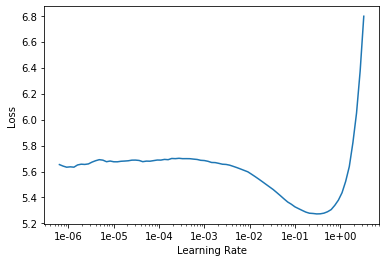

In [58]:
# we typically find the point where the slope is steepest
learn.recorder.plot()

In [60]:
# Fit the model based on selected learning rate
learn.fit_one_cycle(5, 0.5*1e-1, moms=(0.8,0.7))

# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,4.079424,4.093198,0.260184,05:57
1,4.148405,4.133693,0.260854,05:56
2,3.904463,4.059026,0.267597,05:58
3,3.555468,3.987557,0.278488,06:00
4,3.254518,3.975652,0.280952,06:01


# Labelled Dataset

In [3]:
# get unique categories
print(list(data2.label.str[1].unique()))

[nan, 'business_vision_competitors', 'Job Security/Advancement', 'culture_team', 'tech_product', 'management', 'salary_benefits', 'wlb_working_conditions']


In [4]:
# data.loc[:, 'new_label'] = data.label.astype(str)
labels = list(data2.label.str[1].unique())
labels.remove(np.nan)
for col in labels:
    data2.loc[:, col] = (np.where(data2.label.str[2].str.contains(col).fillna(False), 1, 0) |
                       np.where(data2.label.str[1].str.contains(col).fillna(False), 1, 0) |
                       np.where(data2.label.str[0].str.contains(col), 1, 0)
                       )


In [5]:
data2.head()

,label,pp_sent,business_vision_competitors,Job Security/Advancement,culture_team,tech_product,management,salary_benefits,wlb_working_conditions
16,[Job Security/Advancement],developing your skills,0,1,0,0,0,0,0
149,"[Job Security/Advancement, business_vision_com...",rapidly growing,1,1,0,0,0,0,0
220,[Job Security/Advancement],easy to get your foot in the door,0,1,0,0,0,0,0
233,[Job Security/Advancement],opportunity for advancement,0,1,0,0,0,0,0
396,[Job Security/Advancement],career growth options,0,1,0,0,0,0,0


# Re-fit a supervised model using classification labels

In [14]:
# Re-fit model with classification label
train = data2.copy(deep=True)
label_cols = labels

data_clas = (TextList.from_df(train, cols='pp_sent', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
#              .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos would be great if the sexual harassment course that everyone was required to complete would actually be used not sure why the xxunk of our xxunk still gets to make xxunk sexual xxunk as if xxunk is an xxunk to the rule,
xxbos fantastic benefits – from health dental with xxunk covered by the employer to catered lunch to flex time pto to a dog friendly office this certainly helps take the stress levels down a notch,salary_benefits;wlb_working_conditions
xxbos it is a complete xxunk where the upper level boys club or those who got in early will be rewarded while everyone else is xxunk xxunk who will be used for xxunk,management
xxbos lots of different xxunk of businesses so somewhat of a potential for mobility within the company to different business units xxunk to be xxunk though given the xxunk xxunk of ebay,business_vision_competitors
xxbos there is n't a clear best practice as there is too much favoritism among some ' friends within the sales team division from which it creates a level of xxunk,


In [15]:
f_score = partial(fbeta, thresh=0.2)
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=f_score)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


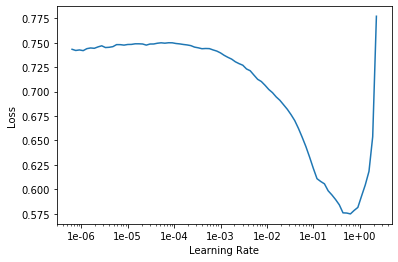

In [16]:
# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()


In [97]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,time
0,0.171352,0.119099,00:37
1,0.167433,0.114570,00:38
2,0.167730,0.112970,00:40
3,0.162903,0.125850,00:40
4,0.160643,0.110538,00:37


In [98]:
learn_classifier.show_results()

text,target,prediction
xxbos your xxunk on package will xxunk a healthy amount of xxunk stock units xxunk that can become very xxunk later on if the stock price happens to double or xxunk xxunk you can stand to last long enough until they fully xxunk num years,business_vision_competitors,
xxbos you do have autonomy in creating a sales plan to help you get over quota but you have to hit the call metrics regardless of your success xxunk with xxunk or decision xxunk thru xxunk xxunk even if that means num xxunk a day,management,
xxbos there are non they xxunk give xxunk a break they work you so hard for very little pay some other higher ups that have no experience xxunk on there butt doing nothing but make much more,management,
xxbos but i stuck with amazon for xxunk num years before getting bored with it because it was growing so fast xxunk from managing num servers to num num servers in num years,Job Security/Advancement,
xxbos xxunk upper management you would know what i mean by xxunk when you listen to xxunk 's all hands meeting you will have to join nvidia for that we are hiring xxunk,management,
